# Resultados

In [ ]:
!pip install matplotlib
!pip install pandas 

In [5]:
import matplotlib.pylab as plt
from matplotlib.pylab import cm
from matplotlib import colors as mcolors
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import itertools

## Graficos Entrenamiento

In [69]:
# Cargar datos y eliminar outliers

def eliminar_outliers(df: pd.DataFrame, columna: str, umbral: float) -> pd.DataFrame:
    return df[df[columna] <= umbral]

df_dqn = pd.read_csv('resultados/resultados_arco_de_entrenamiento_DQN.csv')
df_lstm = pd.read_csv('resultados/resultados_arco_de_entrenamiento_A2C_LSTM.csv')
df_ql = pd.read_csv('resultados/resultados_arco_de_entrenamiento_QLearning.csv')

df_lstm = eliminar_outliers(df_lstm, 'perdida', 200)
df_dqn = eliminar_outliers(df_dqn, 'perdida', 200)


data_entrenamiento_perdida = [(df_dqn, "DeepQ Network"), (df_lstm, "A2C LSTM")]   
data_entrenamiento_exploracion = [(df_ql, "Q-Learning")]   

In [ ]:
# Graficar el progreso de entrenamiento
cmap = cm.plasma    


def plot_perdida_por_torneo(df, titulo, puntos=False):
    
    # Promedio por torneo
    prom = df.groupby('n_torneo')['perdida'].mean().reset_index()

    
    plt.figure(figsize=(12, 6))

    # Línea del promedio por torneo
    plt.plot(prom['n_torneo'], prom['perdida'], color='black', label='Promedio por torneo')


    # Puntos coloreados por magnitud de pérdida
    if puntos:
        # Normalización robusta sobre los valores a graficar (promedios)
        vals = prom['perdida'].values
        vmin = float(vals.min()) if len(vals) else 0.0
        vmax = float(vals.max()) if len(vals) else 1.0
        # Evitar rango cero (todos iguales)
        if vmax == vmin:
            vmax = vmin + 1e-12
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

        colors = cmap(norm(vals))

        sc = plt.scatter(
            prom['n_torneo'],
            prom['perdida'],
            c=prom['perdida'],
            cmap=cmap,
            s=100,
            norm=norm
        )
        # Barra de color
        cbar = plt.colorbar(sc)
        cbar.set_label('Pérdida')

    plt.title(titulo)
    plt.xlabel('Número de torneo')
    plt.ylabel('Pérdida (loss)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()


    plt.legend()
    plt.show()




def plot_exploracion_por_torneo(df, titulo, puntos=False):
    
    # Promedio por torneo
    prom = df.groupby('n_torneo')['exploracion'].mean().reset_index()

    # Normalización robusta sobre los valores a graficar (promedios)
    vals = prom['exploracion'].values
    vmin = float(vals.min()) if len(vals) else 0.0
    vmax = float(vals.max()) if len(vals) else 1.0
    
    # Evitar rango cero (todos iguales)
    if vmax == vmin:
        vmax = vmin + 1e-12
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(vals))

    plt.figure(figsize=(12, 6))

    # Línea del promedio por torneo
    plt.plot(prom['n_torneo'], prom['exploracion'], color='black', label='Promedio por torneo')

    # Puntos coloreados por magnitud de pérdida

    if puntos:
        sc = plt.scatter(
            prom['n_torneo'],
            prom['exploracion'],
            c=prom['exploracion'],
            cmap=cmap,
            s=100,
            norm=norm
        )
        # Barra de color
        cbar = plt.colorbar(sc)
        cbar.set_label('Exploración')

    plt.title(titulo)
    plt.xlabel('Número de torneo')
    plt.ylabel('Exploración')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()


    plt.legend()
    plt.show()


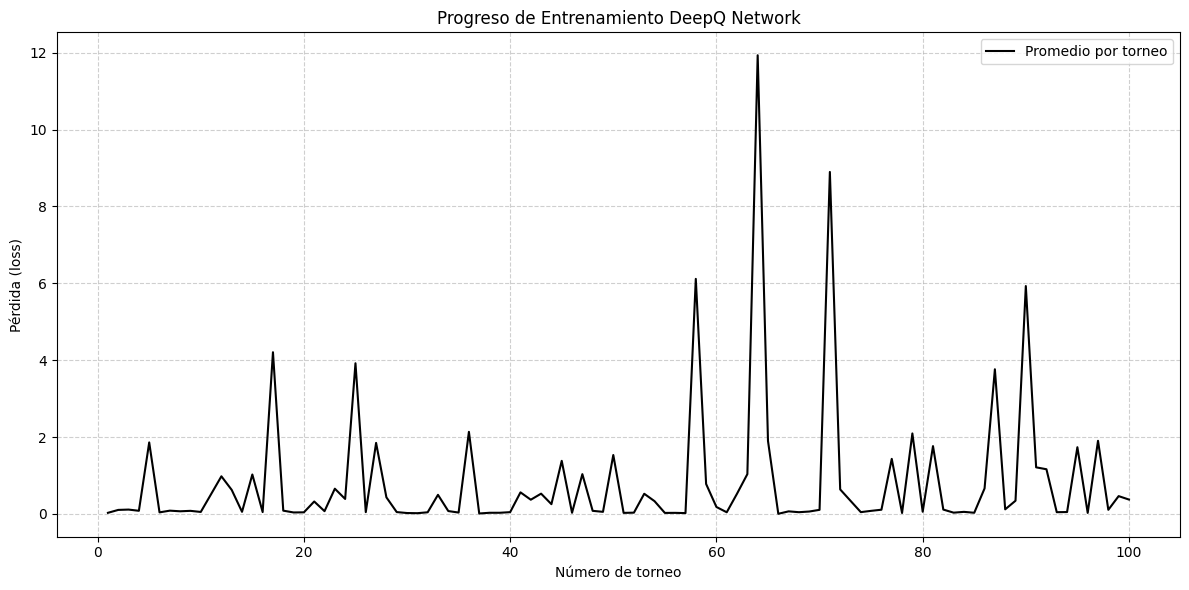

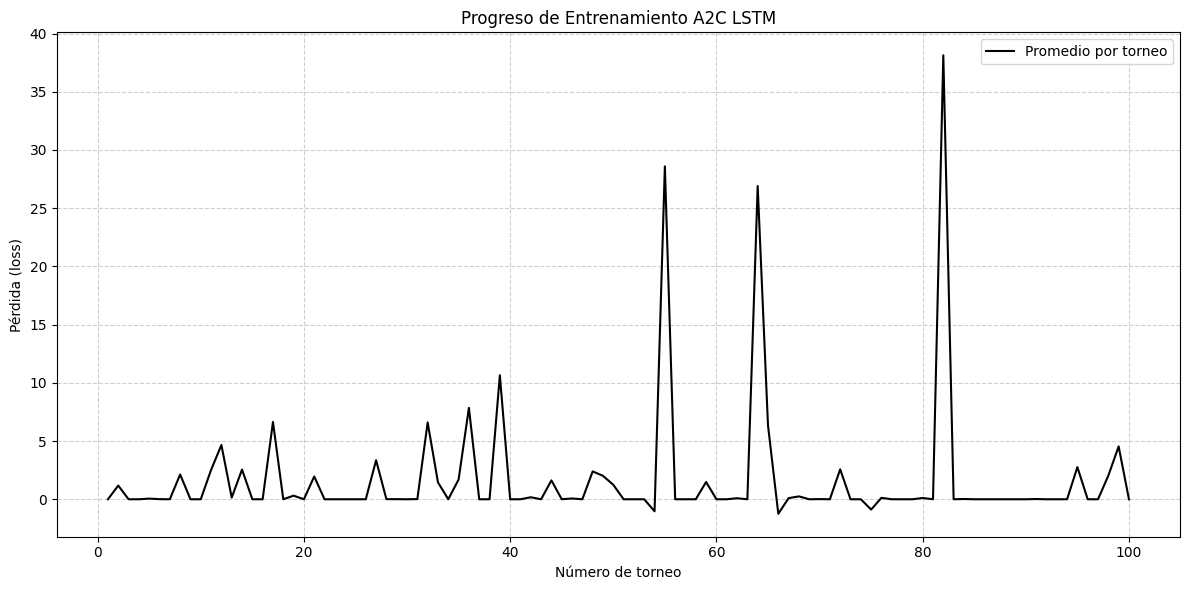

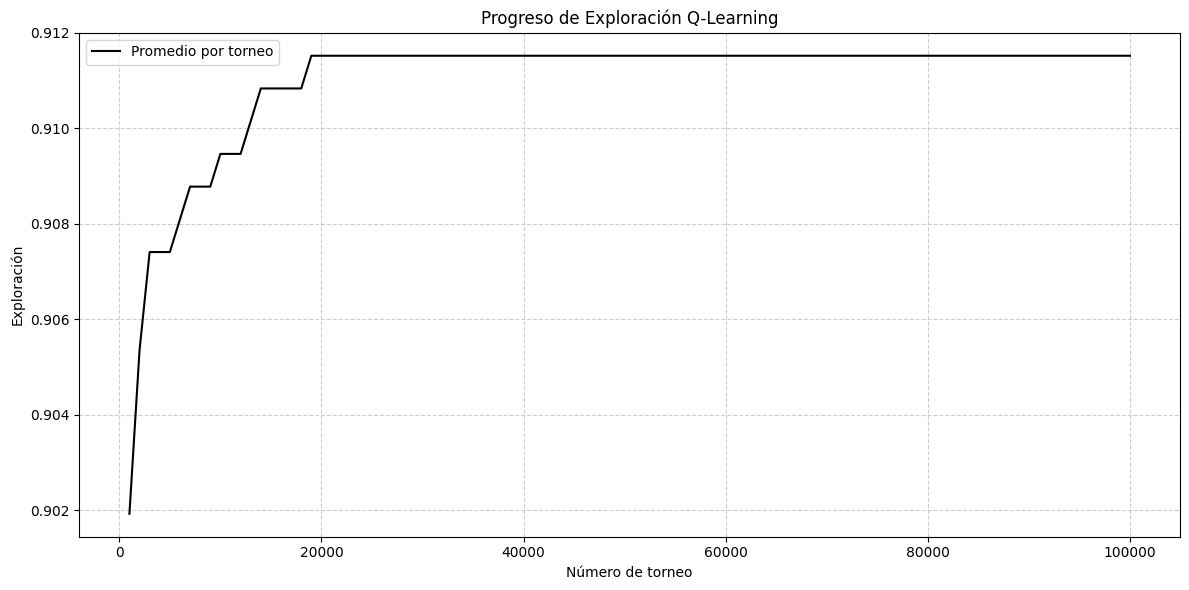

In [70]:
# Graficar progreso de entrenamiento para cada archivo
for f, nombre in data_entrenamiento_perdida:
    plot_perdida_por_torneo(f, f"Progreso de Entrenamiento {nombre}", puntos=False)

for f, nombre in data_entrenamiento_exploracion:
    plot_exploracion_por_torneo(f, f"Progreso de Exploración {nombre}", puntos=False)

## Gráficos Experimentación

In [57]:
# Función: Comparativa ___ vs agentes clásicos (por torneo y acumulado)


def plot_comparativa_estrategias(
    df_scores,
    destacado: List[str] = [],
    titulo_por_torneo: str = 'Puntaje por Torneo: ___ vs agentes clásicos',
    titulo_acumulado: str = 'Puntaje Acumulado: ___ vs agentes clásicos'
) -> Tuple[dict, dict, Dict[str, str]]:
    """
    Traza dos gráficos comparando el desempeño por torneo y acumulado del/los
    agentes destacados contra el resto en una misma figura (dos subplots).

    Parámetros
    ----------
    df_scores : pandas.DataFrame
        Filas representan torneos (en orden) y columnas representan agentes.
    destacado : List[str]
        Lista de nombres de agentes a resaltar (case-insensitive).
    titulo_por_torneo : str
        Título del gráfico de puntaje por torneo.
    titulo_acumulado : str
        Título del gráfico de puntaje acumulado.

    Retorna
    -------
    (promedios, acumulados, colores_destacados) : Tuple[dict, dict, Dict[str, str]]
        Diccionarios con el promedio y el acumulado por agente, y un mapping
        agente_destacado -> color usado en los gráficos.
    """

    if not isinstance(df_scores, pd.DataFrame):
        raise ValueError('df_scores debe ser un pandas.DataFrame')
    if df_scores.empty:
        raise ValueError('df_scores está vacío')

    # Detectar columnas correspondientes a destacados para resaltarlas
    cols = list(df_scores.columns)
    # normalizamos entradas
    destacado_norm = [d.strip().lower() for d in destacado]
    destacado_like: List[str] = []
    for c in cols:
        if c.lower() in destacado_norm:
            destacado_like.append(c)

    otros = [c for c in cols if c not in destacado_like]

    # Paleta de colores distinta por destacado
    # Usamos 'tab10' y si hay más de 10, repetimos con variaciones
    tab10 = list(plt.get_cmap('tab10').colors)
    if len(tab10) == 0:
        tab10 = [
            (0.1216, 0.4667, 0.7059),
            (1.0000, 0.4980, 0.0549),
            (0.1725, 0.6275, 0.1725),
            (0.8392, 0.1529, 0.1569),
            (0.5804, 0.4039, 0.7412),
            (0.5490, 0.3373, 0.2941),
            (0.8902, 0.4667, 0.7608),
            (0.4980, 0.4980, 0.4980),
            (0.7373, 0.7412, 0.1333),
            (0.0902, 0.7451, 0.8118),
        ]

    color_cycle = itertools.cycle(tab10)
    colores_destacados: Dict[str, str] = {}
    for col in destacado_like:
        c_rgba = next(color_cycle)
        # Convertimos a hex para consistencia
        colores_destacados[col] = '#%02x%02x%02x' % (
            int(c_rgba[0] * 255), int(c_rgba[1] * 255), int(c_rgba[2] * 255)
        )

    # --- Preparar figura con dos subplots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

    # --- Subplot 1: puntaje por torneo ---
    # Otros en estilo tenue
    for col in otros:
        ax1.plot(
            df_scores.index + 1,
            df_scores[col],
            label=col,
            linewidth=1.2,
            alpha=0.55,
            zorder=1
        )

    # Destacados con color propio
    for col in destacado_like:
        ax1.plot(
            df_scores.index + 1,
            df_scores[col],
            label=col,
            color=colores_destacados[col],
            linewidth=3.0,
            marker="o",
            markersize=4,
            zorder=5
        )
        y_last = df_scores[col].iloc[-1] if len(df_scores[col]) > 0 else None
        if y_last is not None:
            ax1.annotate(
                col,
                xy=(len(df_scores), y_last),
                xytext=(6, 0),
                textcoords="offset points",
                color=colores_destacados[col],
                weight="bold",
                va="center"
            )

    ax1.set_title(titulo_por_torneo)
    ax1.set_xlabel('Torneo')
    ax1.set_ylabel('Puntaje del torneo')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # handles1, labels1 = ax1.get_legend_handles_labels()
    # order1 = ([labels1.index(c) for c in destacado_like if c in labels1] +
    #           [i for i, l in enumerate(labels1) if l not in destacado_like])
    # handles1 = [handles1[i] for i in order1]
    # labels1 = [labels1[i] for i in order1]
    # ax1.legend(handles1, labels1, ncol=2, frameon=True, framealpha=0.9)

    # --- Resumen numérico ---
    promedios = df_scores.mean().to_dict()
    acumulados = df_scores.sum().to_dict()

    # --- Subplot 2: puntaje acumulado ---
    df_cum = df_scores.cumsum()

    for col in otros:
        ax2.plot(
            df_cum.index + 1,
            df_cum[col],
            label=col + ' (acum.)',
            linewidth=1.2,
            alpha=0.55,
            zorder=1
        )

    for col in destacado_like:
        ax2.plot(
            df_cum.index + 1,
            df_cum[col],
            label=col + ' (acum.)',
            color=colores_destacados[col],
            linewidth=3.0,
            marker="o",
            markersize=4,
            zorder=5
        )
        y_last = df_cum[col].iloc[-1] if len(df_cum[col]) > 0 else None
        if y_last is not None:
            ax2.annotate(
                col + ' (acum.)',
                xy=(len(df_cum), y_last),
                xytext=(6, 0),
                textcoords="offset points",
                color=colores_destacados[col],
                weight="bold",
                va="center"
            )

    ax2.set_title(titulo_acumulado)
    ax2.set_xlabel('Torneo')
    ax2.set_ylabel('Puntaje acumulado')
    ax2.grid(True, linestyle='--', alpha=0.6)

    handles2, labels2 = ax2.get_legend_handles_labels()
    order2 = ([i for i, l in enumerate(labels2) if any(dl in l for dl in destacado_like)] +
              [i for i, l in enumerate(labels2) if not any(dl in l for dl in destacado_like)])
    handles2 = [handles2[i] for i in order2]
    labels2 = [labels2[i] for i in order2]
    ax2.legend(handles2, labels2, ncol=2, frameon=True, framealpha=0.9)

    fig.tight_layout()
    plt.show()

    return promedios, acumulados, colores_destacados

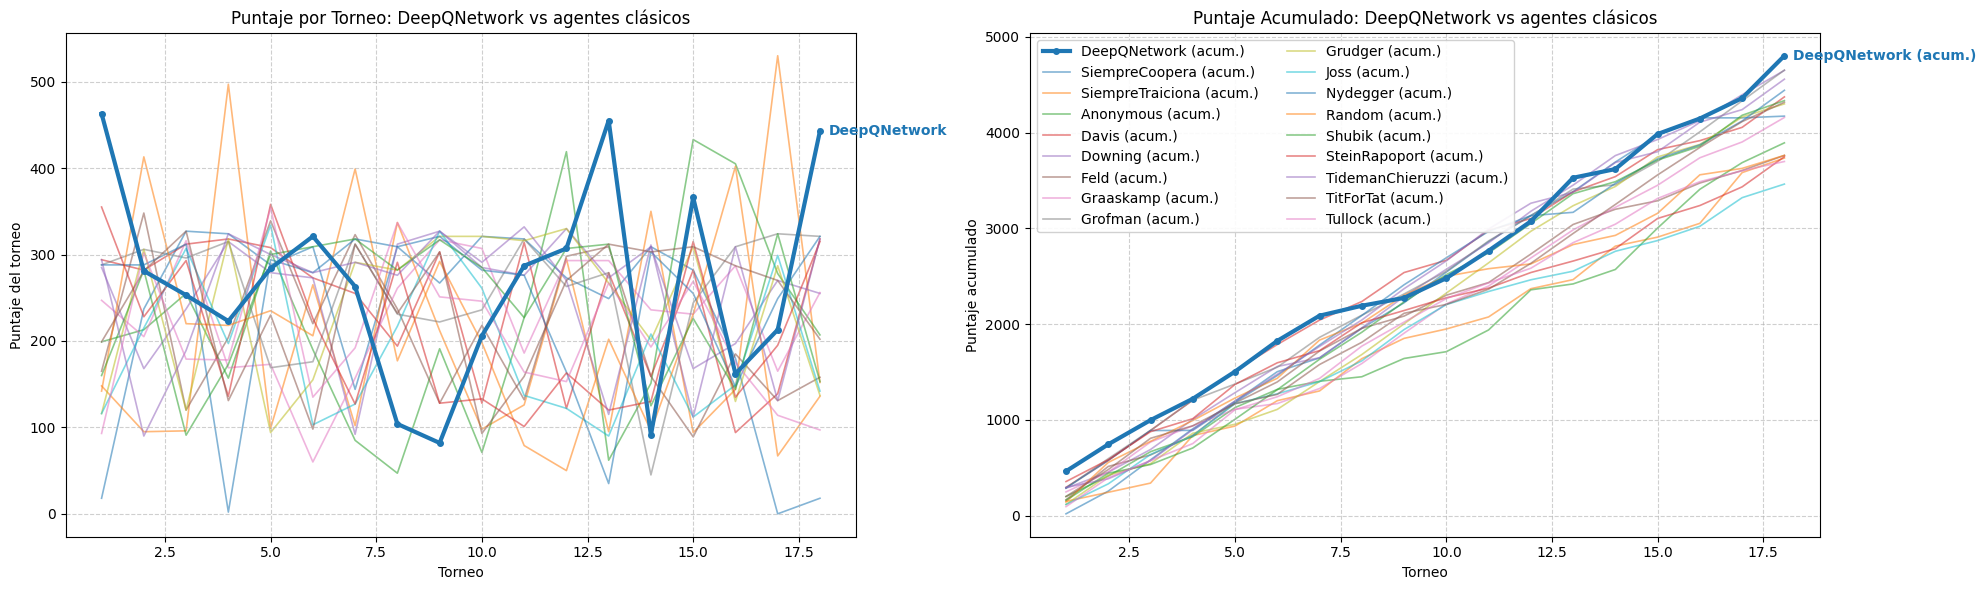

In [ ]:
# Ejemplo de uso de la función con varios destacados
promedios, acumulados, colores = plot_comparativa_estrategias(
    pd.read_csv('resultados/resultado_DQN.csv'),
    destacado=['DeepQNetwork'],
    titulo_por_torneo='Puntaje por Torneo: DeepQNetwork vs agentes clásicos',
    titulo_acumulado='Puntaje Acumulado: DeepQNetwork vs agentes clásicos'
)

# Ejemplo de uso de la función con varios destacados
promedios, acumulados, colores = plot_comparativa_estrategias(
    pd.read_csv('resultados/resultado_A2C_LSTM.csv'),
    destacado=['A2C_LSTM'],
    titulo_por_torneo='Puntaje por Torneo: A2C LSTM vs agentes clásicos',
    titulo_acumulado='Puntaje Acumulado: A2C LSTM vs agentes clásicos'
)

# Ejemplo de uso de la función con varios destacados
promedios, acumulados, colores = plot_comparativa_estrategias(
    pd.read_csv('resultados/resultado_A2C_LSTM.csv'),
    destacado=['A2C_LSTM'],
    titulo_por_torneo='Puntaje por Torneo: A2C LSTM vs agentes clásicos',
    titulo_acumulado='Puntaje Acumulado: A2C LSTM vs agentes clásicos'
)

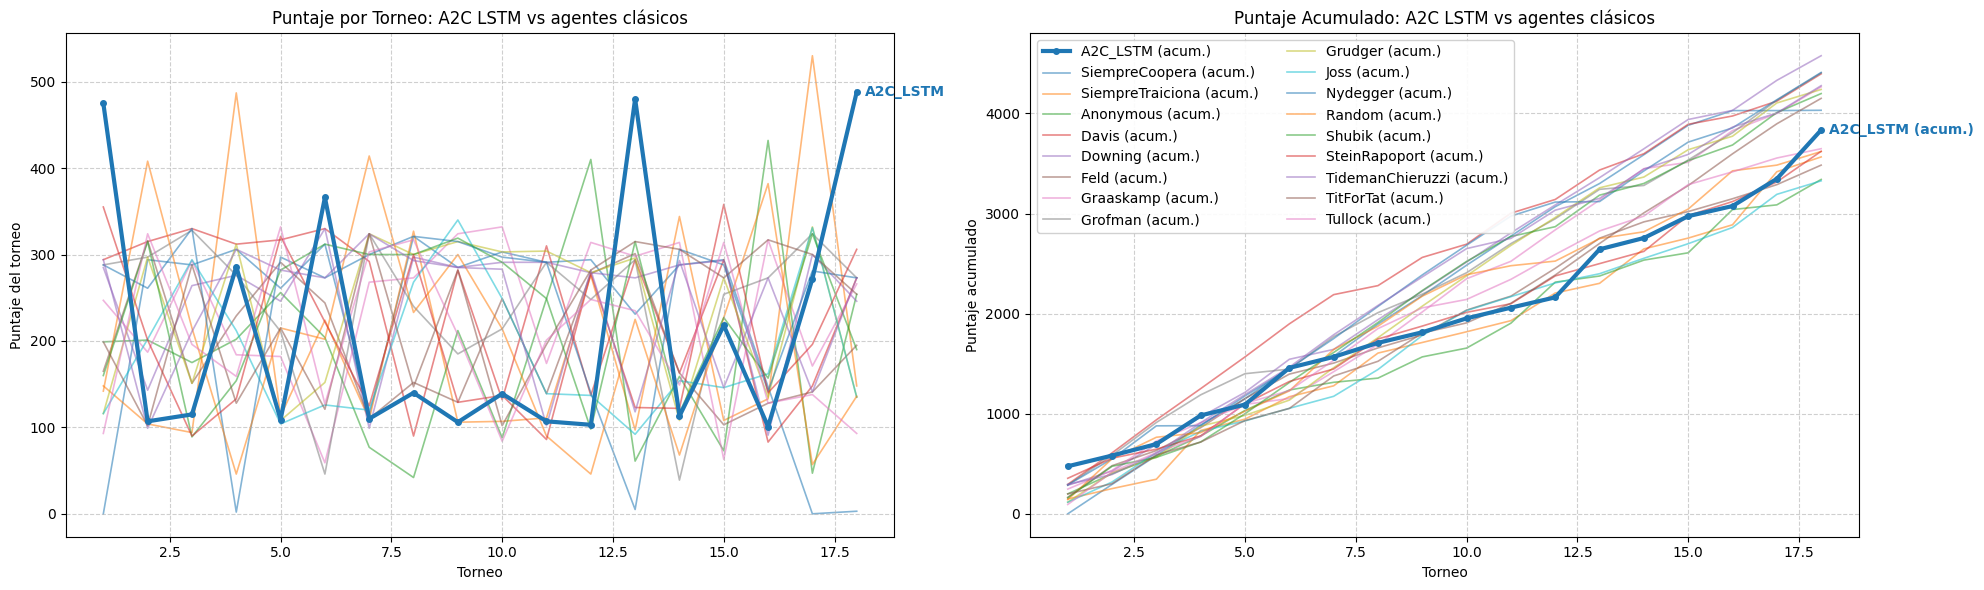